In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [8]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [9]:
min(2000, int(dataset.metadata.feat_static_cat[0].cardinality))

370

In [10]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [11]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a f

In [22]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [23]:
predictor = estimator.train(dataset_train, num_workers=0)

  0%|          | 0/99 [00:00<?, ?it/s]

In [14]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [15]:
forecasts = list(forecast_it)
targets = list(ts_it)

/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/torch/batchify.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.tensor(data, device=device)


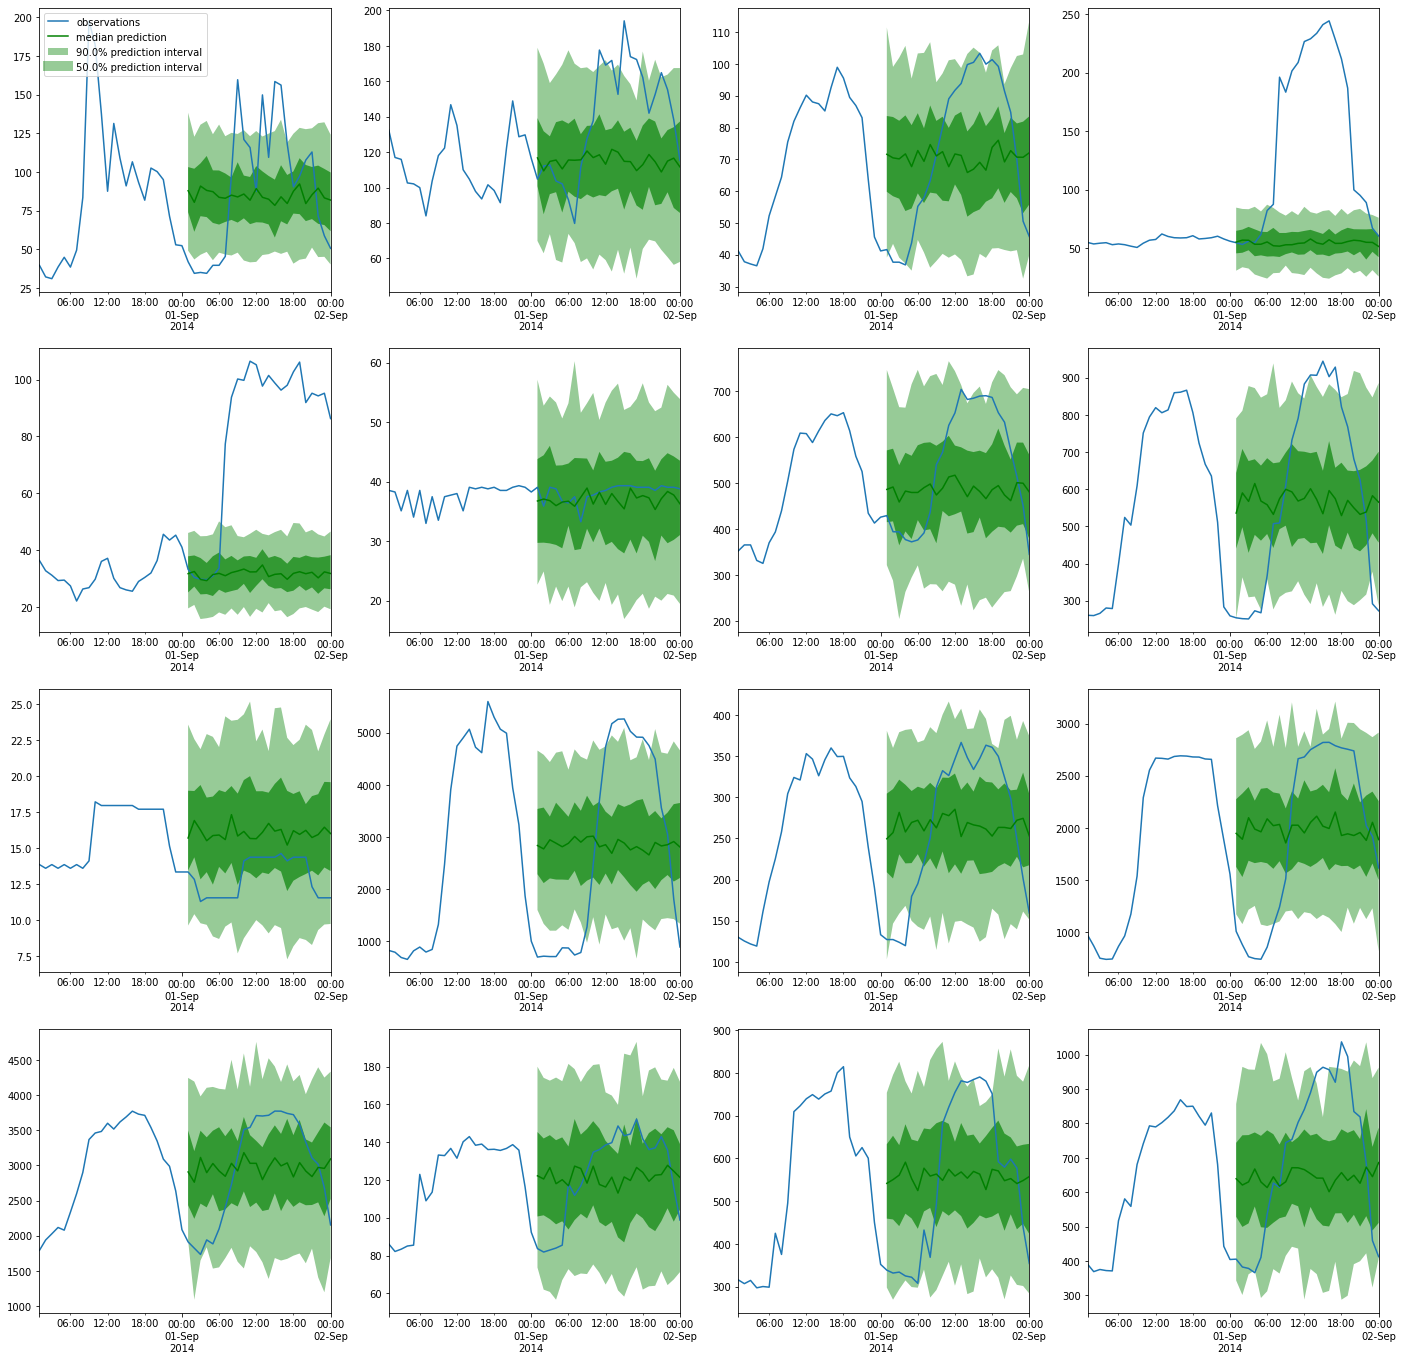

In [16]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [17]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [18]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 182.97it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 238.62it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast 

Running evaluation: 7it [00:00, 244.60it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 260.82it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 247.70it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 242.01it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 253.89it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 249.36it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 243.32it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 253.38it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 252.83it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 249.58it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 244.19it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 253.97it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 249.14it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 250.86it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 251.13it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 245.16it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 247.27it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 250.79it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 248.38it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 246.13it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 251.40it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 252.63it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 248.94it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 247.63it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 241.82it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 251.47it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 247.64it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 246.96it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 252.07it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 244.80it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 245.73it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 250.72it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 246.50it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 244.36it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 244.46it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 251.67it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 237.02it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 242.64it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 243.83it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 240.53it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/metrics.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
Running evaluation: 7it [00:00, 191.41it/s]
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/pandas/core/constru

Running evaluation: 7it [00:00, 242.10it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 248.86it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 246.94it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

Running evaluation: 7it [00:00, 244.58it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 248.65it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 7it [00:00, 244.58it/s]
Running evaluation: 0it [00:00, ?it/s]/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed 

In [19]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.2851919740014067
ND: 0.36879980509653976
NRMSE: 3.4904087846886185

CRPS-Sum: 0.3003463115970928
ND-Sum: 0.34186962395922843
NRMSE-Sum: 0.36454453324752834
